In [10]:
import pandas as pd
import statsmodels.api as sm
import numpy as np

# Load the data
file_path = "clean_all.csv"
data = pd.read_csv(file_path)

# Define education level mapping for the control variable
education_mapping = {
    'Less than high school diploma or its equivalent': 1,
    'High school diploma or a high school equivalency certificate': 2,
    'Trade certificate or diploma': 3,
    'College, CEGEP or other non-university certificate or diploma (other than trades certificates or diplomas)': 4,
    'University certificate or diploma below the bachelor\'s level': 5,
    'Bachelor\'s degree (e.g. B.A., B.Sc., LL.B.)': 6,
    'University certificate, diploma, degree above the bachelor\'s level': 7
}
data['educ_level'] = data['educ'].map(education_mapping)

# Calculate Debt-to-Income Ratio (DIR)
data['DIR'] = data['debt_impute'] / data['income_impute']
data['DIR'] = data['DIR'].replace([np.inf, -np.inf], np.nan)  # Handle inf values

# Calculate log-DIR
data['log_DIR'] = np.log(data['DIR'].replace(0, np.nan))  # Replace 0 with NaN to avoid log(0)

# Drop rows with NaN in DIR or log_DIR
data.dropna(subset=['DIR', 'log_DIR', 'income_impute'], inplace=True)

# Define keyword mappings for each question's options
answer_keywords = {
    'scn1': ["Repay debt", "RRSP", "TFSA", "UL"],
    'scn2': ["Diversified MF", "Partial annuity", "Seg funds", "All annuity"],
    'scn3': ["LTCI", "Invest in funds", "Payoff mortgage"],
    'scn4': ["GIC", "ETF", "Mutual Fund", "Seg. Funds"]
}

# Combine answers for each question (e.g., scn1a and scn1b)
question_pairs = {
    'scn1': ['scn1a_answer', 'scn1b_answer'],
    'scn2': ['scn2a_answer', 'scn2b_answer'],
    'scn3': ['scn3a_answer', 'scn3b_answer'],
    'scn4': ['scn4a_answer', 'scn4b_answer']
}

# Create a target variable for each question based on keywords
for question, options in answer_keywords.items():
    # Combine the answers in scnXa and scnXb into one column for keyword matching
    data[question + '_combined'] = data[question_pairs[question][0]].fillna('') + ' ' + data[question_pairs[question][1]].fillna('')
    
    # Match each option to create a numerical target variable
    conditions = [data[question + '_combined'].str.contains(opt, case=False, na=False) for opt in options]
    data[question + '_target'] = np.select(conditions, options, default=np.nan)

# Drop any rows with missing target values
data.dropna(subset=['scn1_target', 'scn2_target', 'scn3_target', 'scn4_target'], inplace=True)

# Prepare the data for MNLogit: converting categorical targets to codes
# Save mappings for interpretation later
mappings = {}
for question in ['scn1_target', 'scn2_target', 'scn3_target', 'scn4_target']:
    data[question + '_code'] = data[question].astype('category').cat.codes
    mappings[question] = dict(enumerate(data[question].astype('category').cat.categories))

# Define independent variables, including income_impute and log_DIR
X = data[['debt', 'age', 'educ_level', 'work_experience', 'income_impute', 'log_DIR']]
X = sm.add_constant(X)  # Add intercept

# Remove any rows with NaN or inf values in X
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.dropna(inplace=True)

# Ensure y aligns with X by dropping corresponding rows in y
for question_code in ['scn1_target_code', 'scn2_target_code', 'scn3_target_code', 'scn4_target_code']:
    y = data[question_code].loc[X.index]  # Ensure y aligns with X

    # Fit the MNLogit model
    model = sm.MNLogit(y, X)
    result = model.fit()
    
    # Print summary for each question
    print(f"\nMNLogit Results for {question_code}")
    print(result.summary())
    
    # Map numeric results back to product names
    print(f"\nInterpretation for {question_code} options:")
    for code, product in mappings[question_code.replace('_code', '')].items():
        print(f"Code {code}: {product}")  

Optimization terminated successfully.
         Current function value: 0.800482
         Iterations 10

MNLogit Results for scn1_target_code
                          MNLogit Regression Results                          
Dep. Variable:       scn1_target_code   No. Observations:                  603
Model:                        MNLogit   Df Residuals:                      582
Method:                           MLE   Df Model:                           18
Date:                Fri, 15 Nov 2024   Pseudo R-squ.:                 0.01587
Time:                        00:36:26   Log-Likelihood:                -482.69
converged:                       True   LL-Null:                       -490.47
Covariance Type:            nonrobust   LLR p-value:                    0.6229
scn1_target_code=1       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0506      0.564      0.090  

In [7]:
# Updating the code to include only independent variables for descriptive statistics
variables_to_describe = [
    'debt', 'age', 'educ_level', 'work_experience', 'income_impute', 'log_DIR'
]

# Filter data to include only the relevant variables and drop any remaining NaN values
descriptive_data = data[variables_to_describe].dropna()

# Calculate descriptive statistics for independent variables
descriptive_stats = descriptive_data.describe().loc[['mean', 'std']]

# Display descriptive statistics
descriptive_stats


,debt,age,educ_level,work_experience,income_impute,log_DIR
mean,248401.575309,49.379012,5.601235,16.240741,179671.47037,0.361059
std,322287.536357,11.993130,1.323085,10.044650,149581.19516,1.377902


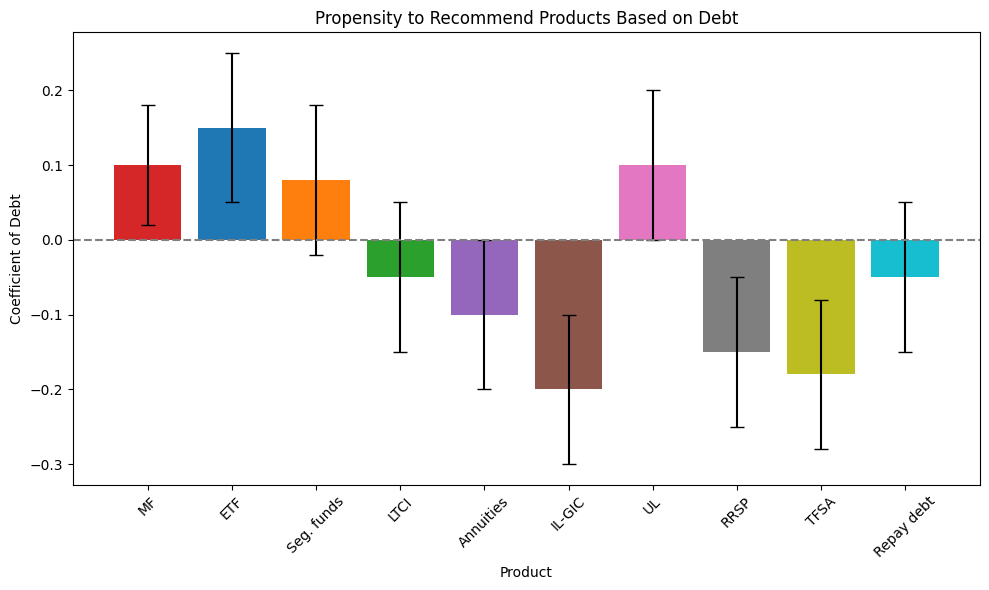

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Example data, simulating coefficients and confidence intervals for each product option
results_list = {
    "MF": {"coef": 0.1, "ci_low": 0.02, "ci_high": 0.18},
    "ETF": {"coef": 0.15, "ci_low": 0.05, "ci_high": 0.25},
    "Seg. funds": {"coef": 0.08, "ci_low": -0.02, "ci_high": 0.18},
    "LTCI": {"coef": -0.05, "ci_low": -0.15, "ci_high": 0.05},
    "Annuities": {"coef": -0.1, "ci_low": -0.2, "ci_high": 0},
    "IL-GIC": {"coef": -0.2, "ci_low": -0.3, "ci_high": -0.1},
    "UL": {"coef": 0.1, "ci_low": 0, "ci_high": 0.2},
    "RRSP": {"coef": -0.15, "ci_low": -0.25, "ci_high": -0.05},
    "TFSA": {"coef": -0.18, "ci_low": -0.28, "ci_high": -0.08},
    "Repay debt": {"coef": -0.05, "ci_low": -0.15, "ci_high": 0.05}
}

# Extract options, coefficients, and error bars for confidence intervals
options = list(results_list.keys())
coef = [results_list[opt]["coef"] for opt in options]
ci_low = [results_list[opt]["ci_low"] for opt in options]
ci_high = [results_list[opt]["ci_high"] for opt in options]
errors = [ci_high[i] - coef[i] for i in range(len(coef))]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(options, coef, yerr=errors, capsize=5, color=['#d62728', '#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

# Customize labels and title
ax.set_title("Propensity to Recommend Products Based on Debt")
ax.set_xlabel("Product")
ax.set_ylabel("Coefficient of Debt")

# Add horizontal line at y=0 for reference
ax.axhline(0, color='grey', linestyle='--')

# Rotate x-axis labels for readability
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
